In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tl
from tensorflow.data import Dataset
import tensorflow_datasets as tfds
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def diffusion_f(t, T, s):
    return np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T+1) # additional slot for t = 0 [0, 1, 2, ..., T]
    f = diffusion_f(t, T, s)  # [f(0), f(1), f(2), ..., f(T)]
    
    alpha = np.clip(f[1:]/f[:-1], 1 - max_beta, 1) # calculate alpha and clip the value for min: 1-max_beta, max: 1
    alpha = np.append(1, alpha).astype(np.float32) # insert alpha0
    beta = 1 - alpha
    alpha_overline = np.cumprod(alpha)

    return alpha, alpha_overline, beta

    
    

In [3]:
T = 500
alpha, alpha_overline, beta = variance_schedule(T)

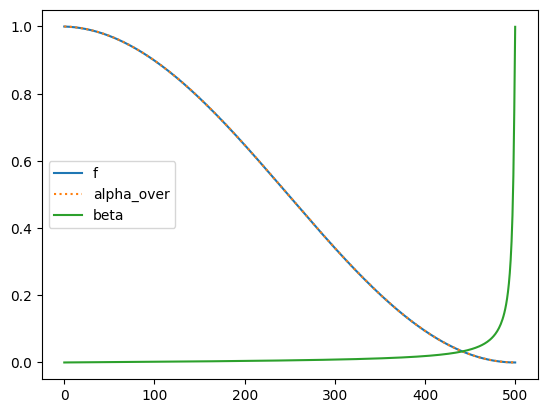

In [4]:
t = np.arange(T+1)

f = diffusion_f(t, T, 0.008)

plt.plot(t, f, label='f')
plt.plot(t, alpha_overline, label='alpha_over', linestyle=':')
plt.plot(t, beta, label='beta')
plt.legend()

plt.show()

In [5]:

def prepare_batch_factory(T, alpha_overline):
    def prepare_batch(X): # values in X should be between 0 ~ 1
        X = X * 2 - 1  # X would be between -1 ~ 1 (similar to gauss normal distribution)
        X_shape = tf.shape(X)
        if len(X_shape) == 3:
            X = tf.cast(X[..., tf.newaxis], tf.float32) # new axis for channel layer
        else:
            X = tf.cast(X, tf.float32)
        
        t = tf.random.uniform([X_shape[0]], minval=1, maxval=T+1, dtype=tf.int32) # t between 1 ~ T
        alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
        alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))  # reshape to [batch_size, 1, 1, 1] for broadcasting
        noise = tf.random.normal(X_shape) # noise with avg = 0, std = 1
    
        X_at_t = (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    
        return {'time': t, 'X_noisy': X_at_t}, noise
    return prepare_batch

def normalize_image(X):
    return tf.cast(X, dtype=tf.float32) / 255.0
    

In [6]:
sprites_file_path = 'assets/sprite/sprites_1788_16x16.npy'
sprites = np.load(sprites_file_path)


In [7]:
print(len(sprites), sprites.dtype)
sprites_train = sprites[:80000]
sprites_valid = sprites[80000:]

89400 uint8


In [8]:
def prepare_dataset(X, T, batch_size=32, shuffle=False):
    _, alpha_overline, _ = variance_schedule(T)
    prepare_batch = prepare_batch_factory(T, alpha_overline)
    ds = Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(buffer_size=int(len(X) * 0.9))
    return ds.batch(batch_size).map(normalize_image).map(prepare_batch).prefetch(1)

train_set = prepare_dataset(sprites_train, T, batch_size=32, shuffle=True)
valid_set = prepare_dataset(sprites_valid, T, batch_size=32)

2024-01-09 19:07:29.181603: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-09 19:07:29.181712: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-09 19:07:29.181746: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-09 19:07:29.182032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 19:07:29.182105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
sample = train_set.take(1)

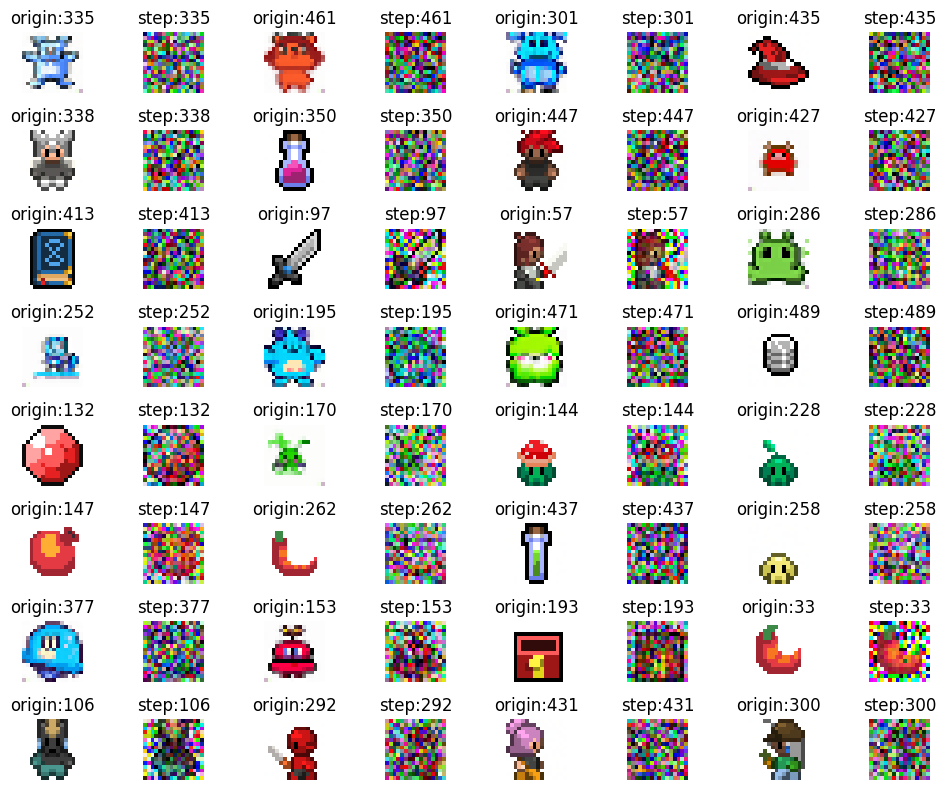

In [10]:
sample, sample_noise = list(sample)[0]
sample_t, sample_X = sample['time'], sample['X_noisy']
# there is value < -1.0 and > 1.0. clipping is required to recover.



def normal_to_image(X):
    return tf.clip_by_value(tf.cast((X + 1.0) / 2.0 * 255.0, dtype=tf.uint8), 0, 255)

def substract_noise(X_noisy, t, noise):
    _, alpha_overline, _ = variance_schedule(T)
    X_shape = tf.shape(X_noisy)
    alpha_o = tf.cast(tf.gather(alpha_overline, t), dtype=tf.float32)
    alpha_o = tf.reshape(alpha_o, [X_shape[0]] + [1] * (len(X_shape)-1))
    
    # reverse of (alpha_o ** 0.5) * X + ((1 - alpha_o) ** 0.5) * noise
    return (X_noisy - ((1 - alpha_o) ** 0.5) * noise) / (alpha_o ** 0.5)

recovered_images = substract_noise(sample_X, sample_t, sample_noise)

fig, axs = plt.subplots(8, 8, figsize=[10,8])
for i in range(len(sample_t)):
    image = normal_to_image(sample_X[i])
    recovered_image = normal_to_image(recovered_images[i])
    
    # print(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].imshow(recovered_image)
    axs[(2*i) // 8, (2*i) % 8].set_title(f'origin:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8].axis('off')

    axs[(2*i) // 8, (2*i) % 8 + 1].imshow(image)
    axs[(2*i) // 8, (2*i) % 8 + 1].set_title(f'step:{tf.keras.backend.get_value(sample_t[i])}')
    axs[(2*i) // 8, (2*i) % 8 + 1].axis('off')
    

plt.tight_layout()


In [11]:
class TimeEncoding(tl.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 ==0, 'embed size must be even number'
        p, i = np.meshgrid(np.arange(T+1), 2 * np.arange(embed_size // 2))
        pos_emb = np.empty((T+1, embed_size)) # T X d_emb 
        pos_emb[:, ::2] = np.sin(p / (10_000 ** (i / embed_size))).T
        pos_emb[:, 1::2] = np.cos(p / (10_000 ** (i / embed_size))).T
        self.time_encodings = tf.constant(pos_emb.astype(self.dtype)) # numpy.empty는 기본적으로 float64로 만들기 때문에 float32 이하를 tensorflow에서 사용하기 위해서는 type 변경이 필오하다.
        # self.supports_masking = True # mask propabation for next layer

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs) # shape: (batch, d_emb)


In [15]:
def build_diffusion_model(input_shape, T, embed_size):
    X_noisy = tl.Input(shape=input_shape, name='X_noisy')
    time_input = tl.Input(shape=[], dtype=tf.int32, name='time')
    time_enc = TimeEncoding(T, embed_size)(time_input) # batch_size X embed_size

    dim = 32
    Z = tl.Conv2D(dim, 3, padding='same')(X_noisy)
    Z = tl.BatchNormalization()(Z)
    Z = tl.Activation('relu')(Z)

    time_Z = tl.Dense(dim)(time_enc)
    Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z # time_Z shape: batch_size X 1 X 1 X dim
    
    skip = Z
    cross_skips = [] # UNet's skip connection betwwen down sampling and upsampling
    
    for dim in (64, 128):
        Z = tl.Activation('relu')(Z)
        
        # inception with keeping W, H but 2x channel size
        Z = tl.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        # inception with keeping W,H, C
        Z = tl.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        cross_skips.append(Z)

        Z = tl.MaxPooling2D(3, strides=2, padding='same')(Z) # half W, H
        skip_link = tl.Conv2D(dim, 1, strides=2, padding='same')(skip) # half W, H

        Z = tl.Add()([Z, skip_link])

        time_Z = tl.Dense(dim)(time_enc)
        Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

        

    for dim in (64, 32):
        # same W, H but 1/2 channel size
        Z = tl.Activation('relu')(Z)
        
        Z = tl.Conv2DTranspose(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        # same W, H but 1/2 channel size
        Z = tl.Conv2DTranspose(dim, 3, padding='same')(Z)
        Z = tl.BatchNormalization()(Z)
        Z = tl.Activation('relu')(Z)

        Z = tl.UpSampling2D(2)(Z) # 2x W, H with repeat value

        skip_link = tl.UpSampling2D(2)(skip) # 2x W, H of skip
        skip_link = tl.Conv2D(dim, 1, padding='same')(skip_link) # 1/2 channel dimension of skip
        Z = tl.Add()([Z, skip_link])

        time_Z = tl.Dense(dim)(time_enc)
        Z = time_Z[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tl.concatenate([Z, cross_skips.pop()], axis=-1) # concat by channel layer
        # print(Z)
        skip = Z

    output = tl.Conv2D(3, 3, padding='same')(Z)

    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[output])
    
    

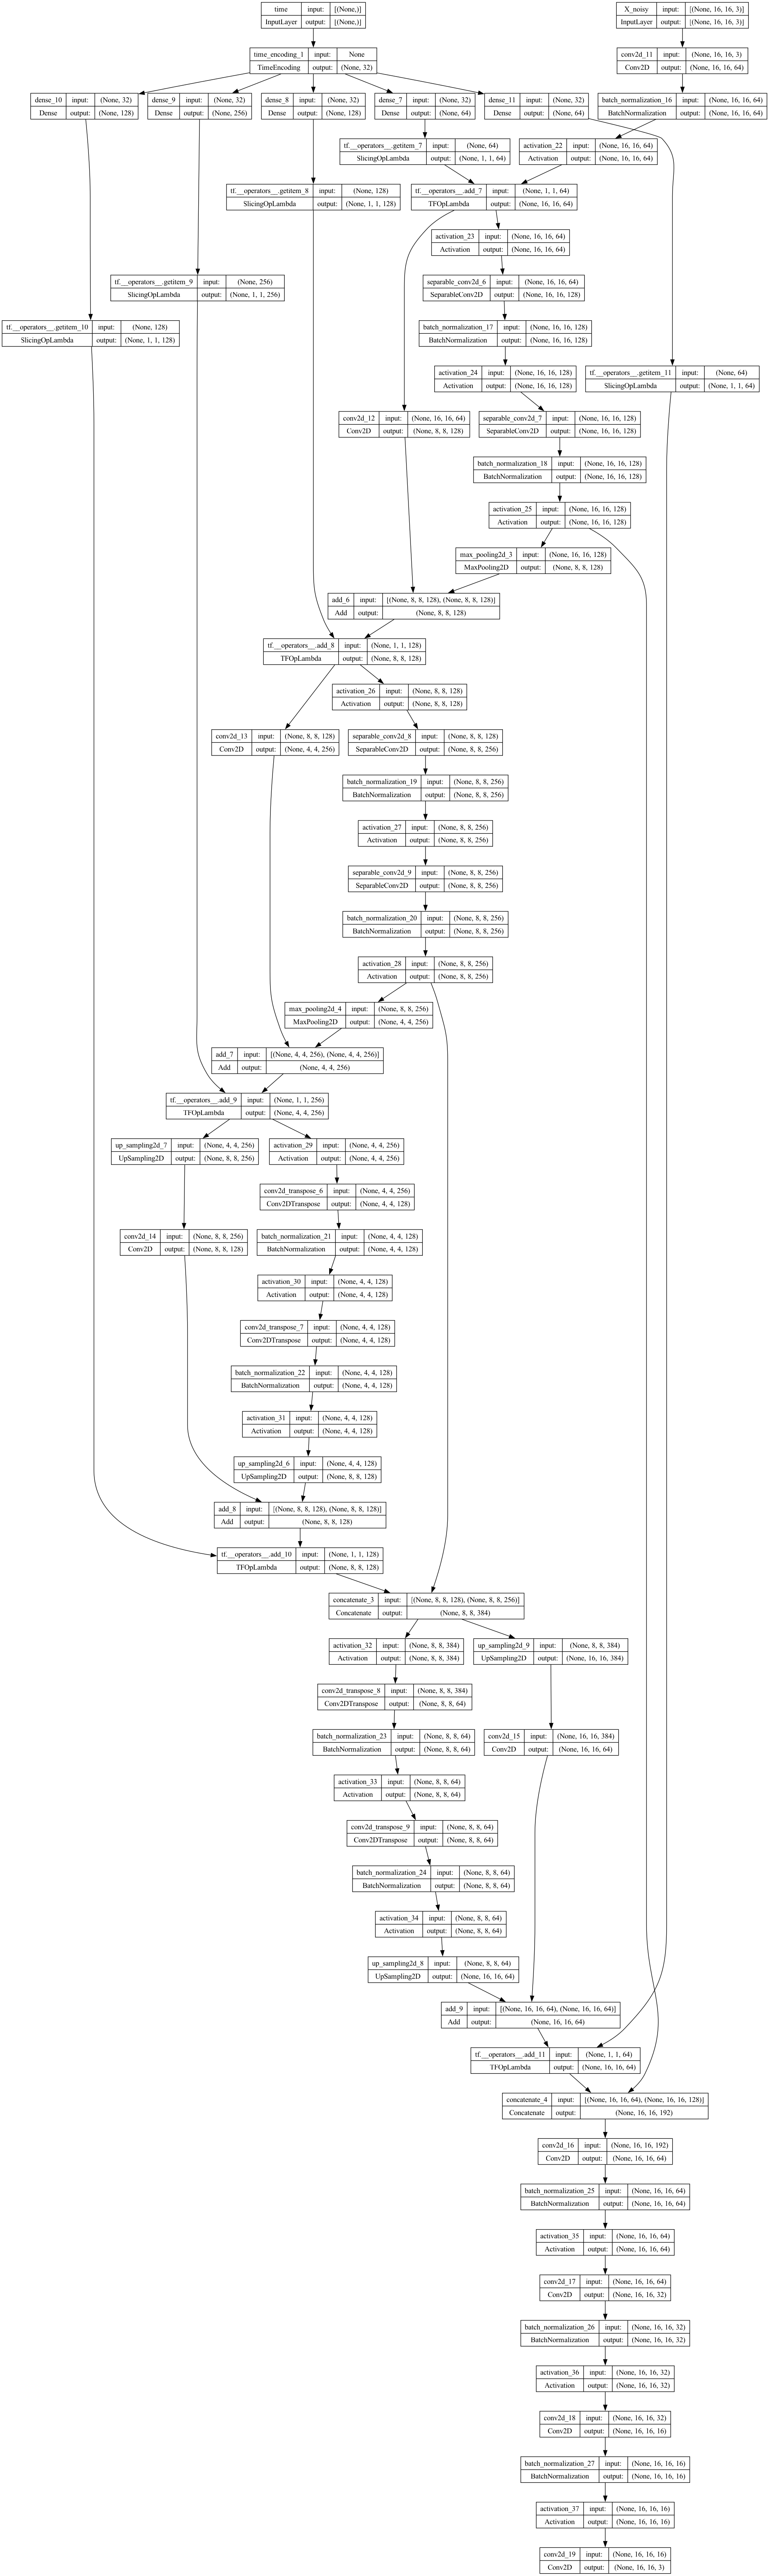

In [16]:
model = build_diffusion_model([16, 16, 3], T, 32)
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='diffusion_mode.png', show_shapes=True, show_layer_names=True)

In [17]:
file_path = Path('models/diffusion_model/model_50.h5')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('checkpoints/diffusion_model', save_best_only=True)

if file_path.is_file():
    model = tf.keras.models.load_model(file_path, custom_objects={'TimeEncoding': TimeEncoding})
else:
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.002)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[checkpoint_cb])
    Path('models/diffusion_model').mkdir(parents=True, exist_ok=True)
    model.save('models/diffusion_model/model_50.h5')

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 0.1778INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 178s 69ms/step - loss: 0.1778 - val_loss: 0.1293
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.1183INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 180s 72ms/step - loss: 0.1183 - val_loss: 0.1047
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.1071INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 171s 68ms/step - loss: 0.1071 - val_loss: 0.1039
Epoch 4/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0971INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 1197s 479ms/step - loss: 0.0971 - val_loss: 0.0969
Epoch 5/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0904INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 176s 70ms/step - loss: 0.0904 - val_loss: 0.0870
Epoch 6/50
2500/2500 [==============================] - 156s 62ms/step - loss: 0.0879 - val_loss: 0.0981
Epoch 7/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0836INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 166s 66ms/step - loss: 0.0836 - val_loss: 0.0800
Epoch 8/50
2500/2500 [==============================] - 177s 71ms/step - loss: 0.0811 - val_loss: 0.0821
Epoch 9/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0801INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 175s 70ms/step - loss: 0.0801 - val_loss: 0.0754
Epoch 10/50
2500/2500 [==============================] - 178s 71ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 11/50
2500/2500 [==============================] - 176s 71ms/step - loss: 0.0758 - val_loss: 0.0793
Epoch 12/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0739INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 179s 72ms/step - loss: 0.0739 - val_loss: 0.0729
Epoch 13/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0725INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 173s 69ms/step - loss: 0.0725 - val_loss: 0.0698
Epoch 14/50
2500/2500 [==============================] - 181s 72ms/step - loss: 0.0717 - val_loss: 0.0715
Epoch 15/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0702INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 184s 74ms/step - loss: 0.0702 - val_loss: 0.0687
Epoch 16/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0691INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 178s 71ms/step - loss: 0.0691 - val_loss: 0.0666
Epoch 17/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0676INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 199s 79ms/step - loss: 0.0676 - val_loss: 0.0657
Epoch 18/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0677INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 178s 71ms/step - loss: 0.0677 - val_loss: 0.0657
Epoch 19/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0666INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 203s 81ms/step - loss: 0.0666 - val_loss: 0.0646
Epoch 20/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0662INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 167s 67ms/step - loss: 0.0662 - val_loss: 0.0624
Epoch 21/50
2500/2500 [==============================] - 174s 70ms/step - loss: 0.0648 - val_loss: 0.0649
Epoch 22/50
2500/2500 [==============================] - 169s 68ms/step - loss: 0.0645 - val_loss: 0.0654
Epoch 23/50
2500/2500 [==============================] - 164s 66ms/step - loss: 0.0636 - val_loss: 0.0634
Epoch 24/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0635INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 172s 69ms/step - loss: 0.0635 - val_loss: 0.0621
Epoch 25/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0630INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 167s 67ms/step - loss: 0.0630 - val_loss: 0.0590
Epoch 26/50
2500/2500 [==============================] - 172s 69ms/step - loss: 0.0621 - val_loss: 0.0614
Epoch 27/50
2500/2500 [==============================] - 173s 69ms/step - loss: 0.0616 - val_loss: 0.0621
Epoch 28/50
2500/2500 [==============================] - 165s 66ms/step - loss: 0.0610 - val_loss: 0.0603
Epoch 29/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0605INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 176s 70ms/step - loss: 0.0605 - val_loss: 0.0588
Epoch 30/50
2500/2500 [==============================] - 158s 63ms/step - loss: 0.0604 - val_loss: 0.0589
Epoch 31/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0598INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 171s 68ms/step - loss: 0.0598 - val_loss: 0.0561
Epoch 32/50
2500/2500 [==============================] - 174s 70ms/step - loss: 0.0594 - val_loss: 0.0583
Epoch 33/50
2500/2500 [==============================] - 170s 68ms/step - loss: 0.0595 - val_loss: 0.0583
Epoch 34/50
2500/2500 [==============================] - 172s 69ms/step - loss: 0.0587 - val_loss: 0.0585
Epoch 35/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0580INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 178s 71ms/step - loss: 0.0580 - val_loss: 0.0553
Epoch 36/50
2500/2500 [==============================] - 170s 68ms/step - loss: 0.0582 - val_loss: 0.0562
Epoch 37/50
2500/2500 [==============================] - 168s 67ms/step - loss: 0.0578 - val_loss: 0.0586
Epoch 38/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0573INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 171s 68ms/step - loss: 0.0573 - val_loss: 0.0547
Epoch 39/50
2500/2500 [==============================] - 177s 71ms/step - loss: 0.0576 - val_loss: 0.0552
Epoch 40/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0562INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 181s 72ms/step - loss: 0.0562 - val_loss: 0.0538
Epoch 41/50
2500/2500 [==============================] - 179s 72ms/step - loss: 0.0562 - val_loss: 0.0551
Epoch 42/50
2500/2500 [==============================] - 181s 72ms/step - loss: 0.0561 - val_loss: 0.0548
Epoch 43/50
2500/2500 [==============================] - 167s 67ms/step - loss: 0.0556 - val_loss: 0.0569
Epoch 44/50
2500/2500 [==============================] - 176s 70ms/step - loss: 0.0552 - val_loss: 0.0576
Epoch 45/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0551INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 183s 73ms/step - loss: 0.0551 - val_loss: 0.0538
Epoch 46/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0551INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 177s 71ms/step - loss: 0.0551 - val_loss: 0.0523
Epoch 47/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0546INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 165s 66ms/step - loss: 0.0546 - val_loss: 0.0522
Epoch 48/50
2500/2500 [==============================] - 165s 66ms/step - loss: 0.0542 - val_loss: 0.0530
Epoch 49/50
2500/2500 [==============================] - 169s 68ms/step - loss: 0.0542 - val_loss: 0.0527
Epoch 50/50
2500/2500 [==============================] - ETA: 0s - loss: 0.0544INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


INFO:tensorflow:Assets written to: checkpoints/diffusion_model/assets


2500/2500 [==============================] - 173s 69ms/step - loss: 0.0544 - val_loss: 0.0519


/Users/yunhongmin/.pyenv/versions/3.10.13/envs/machine-learning-practice-3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
file_path = Path('models/diffusion_model/model_100.h5')

if file_path.is_file():
    model = tf.keras.models.load_model(file_path, custom_objects={'TimeEncoding': TimeEncoding})
else:
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[checkpoint_cb])
    Path('models/diffusion_model').mkdir(parents=True, exist_ok=True)
    model.save('models/diffusion_model/model_100.h5')

In [61]:
def generate(model, T, batch_size=32):
    alpha, alpha_overline, beta = variance_schedule(T)
    X = tf.random.normal([batch_size, 16, 16, 3])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # 추가 코드 - 진행률 표시
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        # X = (X - (beta[t] ** 0.5) * X_noise) / (alpha[t] ** 0.5)
        X = (
            1 / (alpha[t] ** 0.5)
            * (X - beta[t] / ((1 - alpha_overline[t]) ** 0.5) * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [66]:
import time
tf.random.set_seed(time.time())
X_created = generate(model, T)

t = 1   

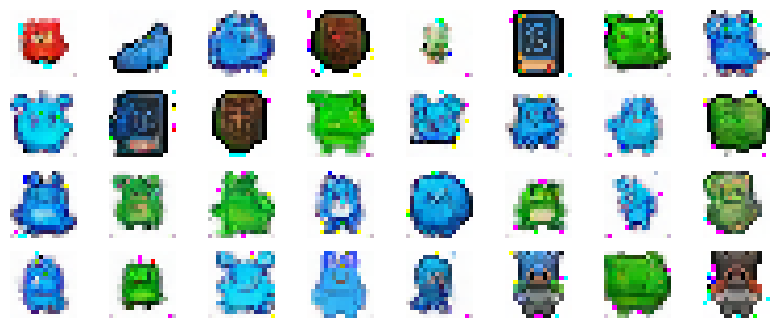

In [67]:
fig, axs = plt.subplots(4, 8, figsize=[10,4])
for i in range(len(X_created)):
    image = normal_to_image(X_created[i])

    axs[i // 8, i % 8].imshow(image)
    axs[i // 8, i % 8].axis('off')